In [18]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from beetroots.modelling.forward_maps.neural_network_approx import NeuralNetworkApprox
from beetroots.space_transform.transform import MyScaler

rng = np.random.default_rng(seed=0)

In [19]:
model_name = "meudon_pdr_model_dense"
env = "horsehead"

assert env in ["all", "horsehead"]

path_model = "../models"

N = 100_000
output_dir = "emir_simulations"
    
dict_is_log_scale_params = {
    "kappa": True,
    "P": True,
    "radm": True,
    "Avmax": True,
    "angle": False,
}

dict_fixed_params_scaled = {
    "kappa": None,
    "P": None,
    "radm": None,
    "Avmax": None,
    "angle": None,
}

if env == "all":
    lower_bounds_lin = np.array([
        1.0e-1,
        1.0e+5,
        1.0e+0,
        1.0e+0,
        0.0,
    ])
    upper_bounds_lin = np.array([
        1.0e+1,
        1.0e+9,
        1.0e+5,
        4.0e+1,
        60.0,
    ])
elif env == "horsehead":
    lower_bounds_lin = np.array([
        1.0e-1,
        10**5.0,
        10**1.0,
        10**0.2,
        0.0,
    ])
    upper_bounds_lin = np.array([
        1.0e+1,
        10**6.5,
        10**2.4,
        10**1.4,
        60.0,
    ])

D = upper_bounds_lin.size

In [20]:
# load scaler + neural network
with open(
    f"{path_model}/{model_name}/scaler.pickle",
    "rb",
) as file_:
    scaler_sklearn = pickle.load(file_)

scaler = MyScaler(
    mean_=scaler_sklearn.mean_.flatten(),
    std_=scaler_sklearn.scale_.flatten(),
    list_is_log=list(dict_is_log_scale_params.values()),
)


forward_map = NeuralNetworkApprox(
    path_model,
    model_name,
    dict_fixed_params_scaled,
    device="cpu",
)

neural network runs on : cpu (asked: cpu)


/users/astro/einig/Python/informative-obs-paper/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
lower_bounds = scaler.from_lin_to_scaled(
    lower_bounds_lin.reshape((1, -1))
).flatten()
upper_bounds = scaler.from_lin_to_scaled(
    upper_bounds_lin.reshape((1, -1))
).flatten()

lower_bounds

array([-2.30258509, -1.61133252, -1.61153002, -1.60793806, -1.5       ])

## Step 1 : iid samples in scaled space

In [22]:
Theta_scaled = (
    (upper_bounds - lower_bounds)[None, :] * rng.uniform(size=(N, D))
    + lower_bounds[None, :]
)
Theta_scaled[:, 0] = 0. # kappa = 1
Theta_scaled[:, -1] = -1.5 # angle = 0 deg

Theta_scaled.shape

(100000, 5)

In [23]:
Theta = scaler.from_scaled_to_lin(Theta_scaled)
log_Theta_nokappa_no_angle = np.log10(Theta[:, 1:-1])
log_Theta_nokappa_no_angle

array([[6.07914686, 0.20486762, 0.02647826],
       [7.4265431 , 3.6474828 , 0.87091985],
       [5.010954  , 4.28702138, 0.05380611],
       ...,
       [6.31764573, 4.98632889, 0.95546403],
       [7.34819195, 3.91981494, 0.74189387],
       [7.20508616, 0.57134807, 0.81506637]])

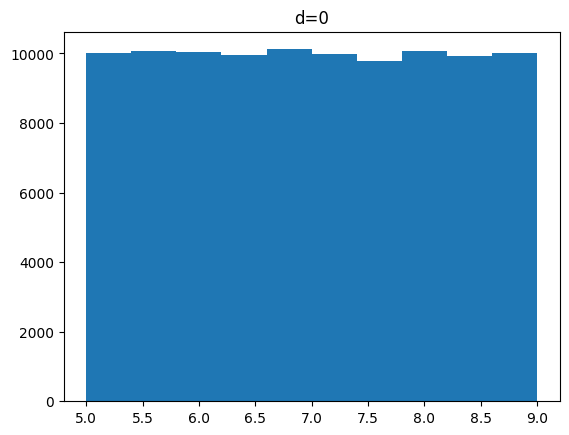

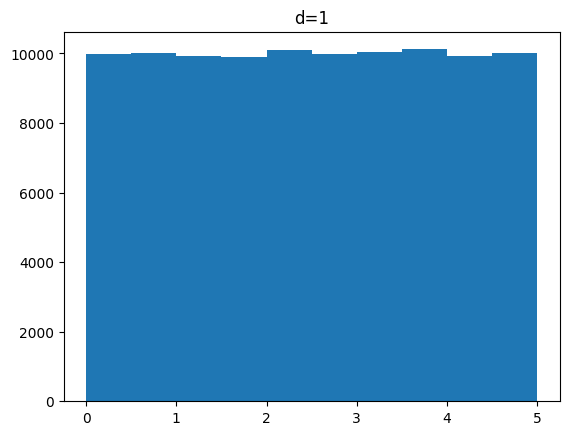

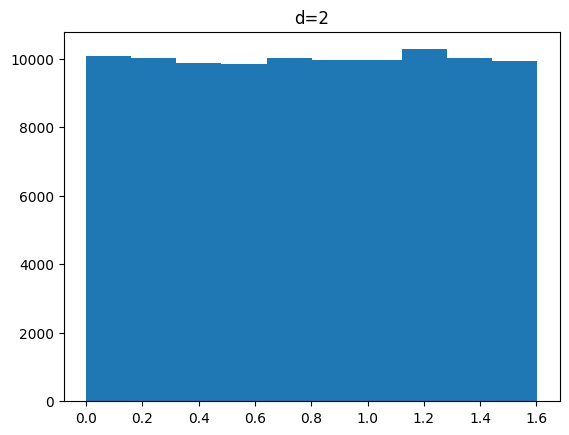

In [24]:
for d in range(3):
    plt.title(f"d={d}")
    plt.hist(log_Theta_nokappa_no_angle[:, d])
    plt.show()

In [25]:
Y = forward_map.evaluate_log(Theta_scaled) / np.log(10.)
Y.shape

(100000, 5375)

In [26]:
list_names = list(dict_is_log_scale_params.keys())[1:-1]
list_lines = list(forward_map.network.current_output_subset)

len(list_names), len(list_lines)

(3, 5375)

In [27]:
df = pd.DataFrame(
    np.hstack((log_Theta_nokappa_no_angle, Y)),
    columns=list_names + list_lines
)
df

,P,radm,Avmax,h2_v0_j2__v0_j0,h2_v0_j3__v0_j1,h2_v0_j4__v0_j2,h2_v0_j5__v0_j3,h2_v0_j6__v0_j4,h2_v0_j7__v0_j5,h2_v0_j8__v0_j6,...,shp_n5_j4_f3d5__n2_j3_f3d5,shp_n5_j4_f4d5__n2_j3_f3d5,shp_n6_j5_f4d5__n3_j4_f3d5,shp_n6_j5_f5d5__n3_j4_f4d5,shp_n7_j6_f5d5__n4_j5_f4d5,shp_n7_j6_f6d5__n4_j5_f5d5,shp_n8_j7_f6d5__n5_j6_f5d5,shp_n8_j7_f7d5__n5_j6_f6d5,shp_n9_j8_f7d5__n6_j7_f6d5,shp_n9_j8_f8d5__n6_j7_f7d5
0,6.079147,0.204868,0.026478,-8.825614,-9.181306,-8.197285,-7.482648,-7.824425,-7.389698,-7.872997,...,-20.347701,-18.806028,-19.797060,-19.707598,-20.517957,-20.440834,-21.257898,-21.193203,-22.051925,-21.996350
1,7.426543,3.647483,0.870920,-4.457699,-3.682691,-3.475364,-3.362907,-4.130669,-4.138643,-4.978065,...,-14.223545,-12.680942,-13.134094,-13.044653,-13.471717,-13.398796,-13.822665,-13.758991,-14.213166,-14.158045
2,5.010954,4.287021,0.053806,-6.673225,-5.808647,-6.600441,-6.451157,-6.894714,-6.494920,-6.915515,...,-17.907003,-16.365691,-16.820606,-16.732859,-17.155574,-17.073749,-17.506122,-17.441025,-17.897443,-17.850764
3,8.452716,2.707306,0.480156,-5.518374,-5.678808,-5.438899,-5.811284,-5.978527,-5.432477,-5.817513,...,-14.052125,-12.507713,-13.104089,-13.016220,-13.593656,-13.521297,-14.086365,-14.024146,-14.600985,-14.546142
4,5.497133,3.353122,1.036836,-4.400503,-4.033351,-4.634828,-5.677701,-6.280342,-5.934356,-6.414074,...,-16.856255,-15.313127,-15.804119,-15.713025,-16.186818,-16.113139,-16.584630,-16.522868,-17.025319,-16.968385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5.940862,4.105326,1.331124,-4.210930,-3.728531,-3.856461,-4.918431,-5.879521,-5.550528,-6.074544,...,-16.009758,-14.464686,-14.939323,-14.852248,-15.309353,-15.234654,-15.697818,-15.631814,-16.125678,-16.071735
99996,8.981083,4.665514,1.224457,-4.534373,-3.563010,-3.490546,-3.045941,-3.437075,-2.960041,-3.499507,...,-12.249423,-10.706493,-11.145157,-11.057212,-11.472174,-11.397910,-11.808266,-11.746222,-12.178888,-12.124072
99997,6.317646,4.986329,0.955464,-4.217660,-3.400412,-3.477035,-4.173591,-5.425805,-5.269006,-5.825266,...,-15.420409,-13.873019,-14.339957,-14.253262,-14.695362,-14.623376,-15.069220,-15.005878,-15.483272,-15.429447
99998,7.348192,3.919815,0.741894,-4.399034,-3.544769,-3.378506,-3.251517,-4.068155,-4.109290,-4.947934,...,-14.235051,-12.691750,-13.135596,-13.047472,-13.468924,-13.395744,-13.814520,-13.751723,-14.199196,-14.143725


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5378 entries, P to shp_n9_j8_f8d5__n6_j7_f7d5
dtypes: float64(5378)
memory usage: 4.0 GB


In [29]:
df["co_v0_j10__v0_j9"].describe()

count    100000.000000
mean         -7.166287
std           2.030822
min         -16.869930
25%          -8.791768
50%          -7.304092
75%          -5.570056
max          -3.158616
Name: co_v0_j10__v0_j9, dtype: float64

In [30]:
emir_df = pd.read_csv("emir_lines_selection/emir_table_filtered.csv")

emir_lines = emir_df["line_id"].to_list()
additional_lines = ["c_el3p_j1__el3p_j0", "c_el3p_j2__el3p_j1", "cp_el2p_j3_2__el2p_j1_2"] # 2 lines of CI, 1 line of C+

sub_df = df[["P", "radm", "Avmax"] + emir_lines + additional_lines]

### Noise

In [31]:
sigma_a = emir_df["Noise RMS (Mathis units, log10) [0.75 min]"].to_list() + [float("-inf"), float("-inf"), float("-inf")]
sigma_a = 10**np.array(sigma_a)

sigma_m = np.log(1.1) # 10% calibration error

size = (sub_df.shape[0], sub_df.shape[1] - 3)

eps_a = rng.normal(loc=0., scale=sigma_a, size=size)
eps_m = rng.lognormal(mean=-(sigma_m**2) / 2, sigma=sigma_m, size=size)

y = eps_m * 10**sub_df.iloc[:, 3:].values + eps_a

sub_df_noise = pd.concat([
    sub_df.iloc[:, :3],
    pd.DataFrame(y, columns=sub_df.columns[3:])
], axis=1)

In [32]:
sub_df.head(5)

,P,radm,Avmax,c2h_n1d0_j1d5_f2d0__n0d0_j0d5_f1d0,hcn_j1_f2__j0_f1,hcop_j1__j0,hnc_j1__j0,cs_j2__j1,c_18o_j1__j0,13c_o_j1__j0,...,c_18o_j3__j2,13c_o_j3__j2,cn_n3_j3d5__n2_j2d5,cs_j7__j6,co_v0_j3__v0_j2,c2h_n4d0_j4d5_f5d0__n3d0_j3d5_f4d0,hcop_j4__j3,c_el3p_j1__el3p_j0,c_el3p_j2__el3p_j1,cp_el2p_j3_2__el2p_j1_2
0,6.079147,0.204868,0.026478,-10.506911,-9.724993,-10.119830,-9.686806,-9.003056,-10.186367,-8.598933,...,-8.672253,-7.096917,-9.201527,-10.274223,-5.720801,-10.380342,-10.234258,-5.936866,-5.565321,-5.839811
1,7.426543,3.647483,0.870920,-10.079330,-9.522798,-8.485771,-10.210943,-7.688218,-8.587035,-7.766326,...,-6.726246,-5.928885,-7.903391,-7.234028,-4.962548,-7.984777,-7.087188,-5.646193,-4.971985,-3.561440
2,5.010954,4.287021,0.053806,-20.359724,-19.765566,-13.571864,-21.344127,-22.126791,-18.131223,-17.190166,...,-16.856902,-15.922654,-17.552677,-22.272422,-14.011863,-20.169962,-15.335295,-10.980338,-10.456489,-4.192856
3,8.452716,2.707306,0.480156,-10.281235,-9.139328,-9.820329,-9.229843,-8.017052,-9.240329,-8.092072,...,-7.464583,-6.307642,-6.848370,-6.797220,-5.166969,-7.487727,-7.773603,-5.858469,-5.192785,-4.967136
4,5.497133,3.353122,1.036836,-11.049351,-9.565660,-8.117523,-10.016553,-7.713005,-8.195925,-7.522375,...,-6.926459,-6.200675,-9.260412,-10.039042,-5.375715,-11.503447,-8.827522,-5.449405,-4.955800,-3.645766


In [33]:
sub_df_noise.head(5)

,P,radm,Avmax,c2h_n1d0_j1d5_f2d0__n0d0_j0d5_f1d0,hcn_j1_f2__j0_f1,hcop_j1__j0,hnc_j1__j0,cs_j2__j1,c_18o_j1__j0,13c_o_j1__j0,...,c_18o_j3__j2,13c_o_j3__j2,cn_n3_j3d5__n2_j2d5,cs_j7__j6,co_v0_j3__v0_j2,c2h_n4d0_j4d5_f5d0__n3d0_j3d5_f4d0,hcop_j4__j3,c_el3p_j1__el3p_j0,c_el3p_j2__el3p_j1,cp_el2p_j3_2__el2p_j1_2
0,6.079147,0.204868,0.026478,1.360095e-10,-2.161158e-10,1.986286e-10,1.391051e-10,1.112298e-09,5.792444e-10,3.196064e-09,...,3.096373e-07,-5.762295e-08,-1.393004e-07,-6.763974e-08,1.702507e-06,4.435621e-08,5.524110e-08,1.219334e-06,3.287256e-06,0.000001
1,7.426543,3.647483,0.870920,3.196176e-10,4.838867e-10,3.193695e-09,2.588151e-10,2.063959e-08,1.751714e-09,1.505711e-08,...,2.281918e-07,4.561804e-07,1.263549e-07,1.366290e-07,1.241860e-05,-2.134293e-07,1.686108e-07,2.532837e-06,1.242843e-05,0.000285
2,5.010954,4.287021,0.053806,1.315440e-10,-8.542684e-11,-1.051787e-12,-1.227405e-10,8.936634e-11,-1.841967e-12,-1.680811e-09,...,3.042515e-07,-2.540085e-07,-1.111181e-07,2.658878e-08,3.803782e-09,1.614146e-07,1.060117e-07,9.365743e-12,3.722303e-11,0.000071
3,8.452716,2.707306,0.480156,-3.180588e-10,3.356186e-10,4.381334e-11,5.223927e-10,8.825341e-09,2.923209e-10,8.039631e-09,...,1.708416e-07,8.510627e-07,8.161671e-08,4.510345e-07,6.720542e-06,-1.687741e-07,-2.042580e-07,1.519325e-06,7.016042e-06,0.000010
4,5.497133,3.353122,1.036836,-1.260915e-10,3.552873e-10,7.317472e-09,1.057796e-10,1.915214e-08,6.632116e-09,2.844492e-08,...,1.968503e-07,4.497853e-07,-1.990810e-08,2.377314e-07,4.806950e-06,1.467889e-07,1.560954e-07,3.398154e-06,1.051542e-05,0.000209


### Save

In [34]:
# sub_df_noise.to_pickle(os.path.join(output_dir, f"{env}.pkl"))